# <center>Predicting p53 Mutants
<center>
    <b>Nwachukwu Anthony</b><br>
    <b>Otomiewo Tega</b><br>
    <b>Aning Samuel</b> 
</center> 

## 1. Description of data set

**DataSet Name**: p53 Mutants

**Goal:**
The goal is to model mutant p53 transcriptional activity (active vs inactive) based on data extracted from biophysical simulations.

**Dataset Source:**
Richard H. Lathrop, UC Irvine, http://www.ics.uci.edu/~rickl

**Link to Data Set**
https://www.kaggle.com/anthonyemeka12/k8-mutant-2010

**Data Type:**
Multivariate

**Task:**
Classification

**Attribute Type:**
Real

**Area:**
Life Sciences

**Format Type:**
Matrix

**Missing Values:**
Yes

**Intances:**
16772

**Attributes:**
5409

**Relevant Information:**
Biophysical models of mutant p53 proteins yield features which can be used to predict p53 transcriptional activity.  All class labels are determined via in vivo assays.

**Attribute Information:**
There are a total of 5409 attributes per instance. Attributes 1-4826 represent 2D electrostatic and surface based features. Attributes 4827-5408 represent 3D distance based features. Attribute 5409 is the class attribute, which is either active or inactive. The class labels are to be interpreted as follows: 'active' represents transcriptonally competent, active p53 whereas the 'inactive' label 
represents cancerous, inactive p53.  Class labels are determined experimentally.

## 2. Import required Libraries

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import more_itertools as mit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as pre
from sklearn.preprocessing import StandardScaler as ssc
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

## 3. Data Exploration

### 3.1 Load the data

In [2]:
#Load the data which was changed from .data to .csv
print(os.listdir("../input"))
datr = pd.read_csv("../input/K8.csv",low_memory=False)

['K8.csv']


### 3.2 Print the data summary
We discovered the presence of NaN in all the rows from the data description

In [3]:
datr.describe()

,Unnamed: 5409
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


### 3.3. Check the data head
From the data head, we understood the following: 
* **?** was used to indicate **NaN**
* the presence of numbers with double decimal points
* the last column is completely without data
* the first row of the data is used as column header  

We will try to fix these in the data cleaning section

In [4]:
datr.head()

,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,-0.030,-0.050,-0.031,-0.036.1,-0.093.1,-0.008,-0.030.1,-0.023,-0.036.2,-0.042,-0.038,-0.036.3,-0.088,-0.102,-0.021,-0.031.1,-0.053,-0.257,-0.114,-0.075,-0.037,0.080,0.027,-0.161.1,0.056,-0.004,0.002.1,0.003,-0.033.1,-0.056133333333333306,...,-0.051.11,-0.005.34,0.028.20,-0.035.20,-0.004.31,0.011.29,0.026.17,-0.087.6,-0.034.21,-0.048.14,-0.015.31,0.027.20,-0.07,-0.086.6,-0.027.25,-0.013.23,-0.001.39,0.035.19,-0.033.21,0.009.28,0.046.8,0.033.15,0.037.12,0.006.28,0.012.28,-0.032.18,-0.025.35,-0.015.32,-0.015.33,0.006.29,0.013.37,0.021.23,0.02.5,0.016.30,-0.011.30,0.003.35,0.01.6,-0.007.28,inactive,Unnamed: 5409
0,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,-0.007,-0.010,-0.009,-0.017,-0.024,0.002,0.003,-0.011,-0.013,-0.010,-0.019,-0.017,-0.023,-0.044,-0.004,-0.019,-0.033,-0.187,-0.074,-0.057,-0.044,0.044,0.006,-0.146,0.009,-0.017,-0.009,-0.008,-0.029,-0.010433333333333331,...,-0.016,-0.003,0.028,0.021,0.004,-0.001,0.054,-0.035,-0.043,-0.037,-0.011,0.034,-0.078,-0.086,-0.006,-0.002,-0.007,0.011,-0.01,0.002,0.027,0.029,0.021,0.018,0.011,-0.025,-0.016,-0.008,-0.007,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,inactive,NaN
1,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,inactive,NaN
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,-0.032,-0.043,-0.033,-0.046,-0.094,-0.017,-0.042,-0.022,-0.033,-0.039,-0.044,-0.040,-0.091,-0.132,-0.035,-0.036,-0.062,-0.258,-0.133,-0.097,-0.070,0.069,0.014,-0.177,0.053,-0.006,-0.002,-0.005,-0.031,-0.07016666666666667,...,-0.041,-0.011,0.029,-0.04,-0.013,-0.009,0.023,-0.076,-0.038,-0.039,-0.022,0.033,-0.077,-0.087,-0.024,-0.021,-0.005,0.036,-0.027,0.019,0.048,0.04,0.051,0,0.015,-0.039,-0.025,-0.029,-0.016,0.019,0.01,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,inactive,NaN
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,-0.044,-0.097,-0.052,-0.079,-0.175,-0.040,-0.084,-0.030,-0.047,-0.058,-0.067,-0.063,-0.148,-0.228,-1.008,-0.058,-0.094,-0.315,-0.204,-0.156,-0.122,0.081,0.007,-0.204,0.084,0.003,-0.000,-0.008,-0.028,-0.1135,...,-0.111,-0.035,0.056,-0.089,-0.026,-0.016,0.022,-0.124,-0.034,-0.035,-0.041,0.05,-0.078,-0.084,-0.031,-0.041,0.005,0.059,-0.044,0.04,0.07,0.054,0.088,-0.011,0.02,-0.058,-0.047,-0.057,-0.028,0.051,0.012,0.05,0.038,0.051,-0.015,0.017,0.027,-0.049,inactive,NaN
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,0.006,-0.002,-0.004,-0.009,-0.011,0.006,0.015,-0.008,-0.009,-0.004,-0.010,-0.011,-0.007,-0.016,0.005,-0.011,-0.022,-0.161,-0.058,-0.043,-0.030,0.041,0.008,-0.133,-0.000,-0.020,-0.012,-0.010,-0.029,3.333333333333382e-5,...,-0.054,-0.015,0.014,-0.035,-0.009,-0.015,-0.002,-0.035,-0.049,-0.065,-0.005,-0.012,-0.092,-0.079,-0.039,0.003,-0.004,0.009,0.004,-0.001,0.024,0.061,0.011,-0.031,0.073,0.034,0.017,0.037,0.027,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,inactive,NaN


## 4. Data Cleaning

### 4.1 Work on the columns title, first row and last column
It is clear that the first row of the data was used as columns titles and the last column is unneccessary (empty). So we:  

**1.** take column title to row 1  
**2.** convert it to numbers (because we discovered it is a string)  
**3.** create a sequence of integers and used it as column title  
**4.** remove the last column

In [5]:
#Remove the column title of datr, make it row one, then make the column title integer values
datrcolumn=pd.DataFrame(list(datr.columns)).T
datr.columns = datrcolumn.columns
datrefined=datrcolumn.append(datr, ignore_index = True)

#Remove the last column of datrefined
datrefined.drop(columns = list(datrefined.columns)[-1],inplace=True)

### 4.2 Dealing with numbers with more than one decimal point

Some values contain more than one decimal points. We removed the second decimal points with the digits that follows it. This makes the value consistent with other values.

In [6]:
#Remove the second decimal points with the digits that follows it
for i in range(0,len(datrefined.iloc[0])):
    datrefined[i]=datrefined[i].apply(lambda x: x[:list(mit.locate(x, lambda s: s == "."))[1]] if x.count('.') > 1 else x)

### 4.3 Dealing with Missing values

The handle missing numbers, we did the following:  
1. Some columns contain <b>?</b>. We first converted them to **NaN**.
2. There is posibility of columns containing other numeric values in form of strings, we try to change every elements in each column to numbers(numerical values that were entered as strings will convert) and if it's not possible (in case on non-numerical values) force then to be <b>NaN</b>, (except the last column).
3. Drop all rows and columns with all elements <b>NaN</b> or whose rows contains <b>NaN</b> more than 90% of the column numbers

In [7]:
# Change string numerical values to numbers
datrefined.iloc[:,:-1]=datrefined.iloc[:,:-1].apply(pd.to_numeric, errors='coerce')
# Drop all rows NaN
datrefined.dropna(axis=0, how='all', inplace=True)
# Drop all columns NaN
datrefined.dropna(axis=1, how='all', inplace=True)
# Drop rows/ with over 90% of the column with NaN
datrefined.dropna(axis=0, thresh=datrefined.shape[1]*90//100, inplace=True)
# Print the total number of rows dropped.
print('Total number of rows dropped is '+str(datr.shape[0]-datrefined.shape[0]))
# Check if there are still missing missing data in the dataset
missingSum = datrefined.isnull().sum().sum()
print('The total number of missing values is: ',missingSum)

Total number of rows dropped is 179
The total number of missing values is:  0


### 4.4 Set index as numbers
Give the rows integer numbering

In [8]:
datrefined.index = list(range(0,datrefined.shape[0]))

### 4.5 Encode the target variables
We will use Label Encoder to label the categorical data. Computer performs faster with numbers than strings. Hence we change out target values to numbers 0 and 1 for inactive and active respectively.

In [9]:
#Encoding categorical data values
labelencoder_y = LabelEncoder()
datrefined[datrefined.columns[-1]] = labelencoder_y.fit_transform(datrefined[datrefined.columns[-1]])

## 5. Split Dataset to Train and Test Sets
Finally, we'll split the data into predictor variables and target variable, following by breaking them into train and test sets. We will use 20% of the data as test set.

In [10]:
datrefined.rename(columns={datrefined.columns[-1]:'target'}, inplace=True)
y = datrefined['target'].values
X = datrefined.drop('target', axis=1).values

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.20, random_state=21)

## 6. Standardize the Data

We use StandardScaler to help standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. Also, data need to be standardized before employing Principal Components Analysis.

In [11]:
# Standardizing the features
X = ssc().fit_transform(X)
X_train = ssc().fit_transform(X_train)
X_test = ssc().fit_transform(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by 

## 7. Visualize the Data by PCA Projection to 2D

Since the data has much features(5409 columns), to be able to visualize it, we apply PCA to reduce the dimension. In this section, the code projects the original data which is 5409 dimensional into 2 dimensions. It should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.


### 7.1 Project to 2 Dimensions

In [12]:
pcaPlot = PCA(n_components=2)
pcaPlot.fit(X)
principalComponents = pcaPlot.transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

### 7.2 Concatenate the Principal compoments and y, then rename y to <b>target</b>. Call it pcaForPloting.

In [13]:
pcaForPloting = pd.concat([principalDf, datrefined['target']], axis = 1, join='inner')
pcaForPloting.rename(columns={datrefined.columns[-1]:'target'}, inplace=True)

### 7.3 Print the head

In [14]:
pcaForPloting.head()

,principal component 1,principal component 2,target
0,12.791937,14.874703,1
1,-4.252133,21.160289,1
2,8.276538,-15.280916,1
3,31.695948,-11.076907,1
4,-16.358272,-28.868594,1


### 7.4 Make the plot

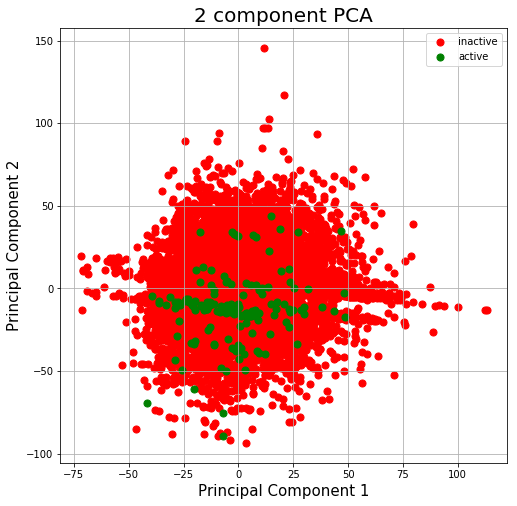

In [15]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targetss = ['inactive', 'active']
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pcaForPloting['target'] == target
    ax.scatter(pcaForPloting.loc[indicesToKeep, 'principal component 1']
               , pcaForPloting.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targetss)
ax.grid()

## 8. Dimensional Reduction
We Project the data with PCA to retain 90% of Variance

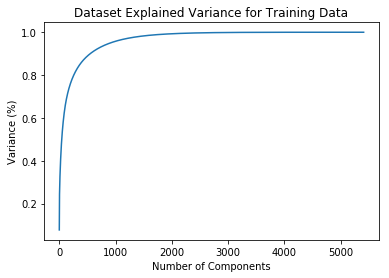

Selecting 534 X_train components we can preserve 0.9 of the total variance of the data.
Selecting 534 X_test components we can preserve 0.9 of the total variance of the data.


In [16]:
#Fitting the PCA algorithm with our Data
pcaModel = PCA().fit(X)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pcaModel.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance for Training Data')
plt.show()

#Reducing the data dimension to retain .90 variance
varianceToPreserve = 0.90

pca = PCA(varianceToPreserve)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('Selecting '+str(X_train.shape[1])+' X_train components we can preserve '+str(varianceToPreserve)+' of the total variance of the data.')
print('Selecting '+str(X_test.shape[1])+' X_test components we can preserve '+str(varianceToPreserve)+' of the total variance of the data.')

## 9. Building the Models
From the dataset, we will build a model to predict if mutant p53 transcriptional is **active** or **inactive**. This is a binary classification problem, and a few algorithms are appropriate for use. Since we do not know which one will perform the best at this time, we will do a quick test on the few appropriate algorithms with default setting to get an early indication of how each of them perform. We will use **10** fold cross validation for each testing.

The following non-linear algorithms will be used, namely:
1. Classification and Regression Trees (CART)
2. Linear Support Vector Machines (SVM)
3. Gaussian Naive Bayes (NB) and 
4. k-Nearest Neighbors (KNN).

In [17]:
# Building a list of models to use
models_list = []
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('SVM', SVC())) 
models_list.append(('NB', GaussianNB()))
models_list.append(('KNN', KNeighborsClassifier()))

In [18]:
# Building the Models
num_folds = 4
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds, random_state=123)
    start = time.time()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

CART: 0.985685 (0.002339) (run time: 47.727902)


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

SVM: 0.991487 (0.000913) (run time: 565.636271)
NB: 0.747456 (0.078423) (run time: 0.531086)
KNN: 0.992014 (0.000657) (run time: 176.773150)


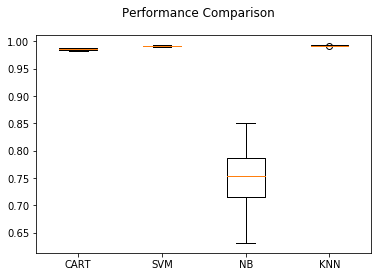

In [19]:
# Making Performance plots
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The yellow line in the boxplots indicate the mean of the performance on training set of the folds used for each model. We discover that **KNN** performed best followed by **CART** and the least is Nearest neighbour(**KN**). This is not good enough to determine the best model to choose as we shall in the next analysis.

## 10. Check Accuracy on the Test Set
Let's fit the models to the dataset and see how it performs given the test data.

In [20]:
# prepare the model
predictions = []
for name, model in models_list:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    print( "Run Time for %s is : %f" % (name, end-start))
    
    # estimate accuracy on test dataset
    pred = model.predict(X_test)
    predictions.append((name, pred))


Run Time for CART is : 20.287241


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Run Time for SVM is : 249.293992
Run Time for NB is : 0.145929
Run Time for KNN is : 0.532061


In [21]:
for name, pred in predictions:
    print('Results for '+name+' :::')
    print("  Accuracy score %f" % accuracy_score(y_test, pred))
    print(classification_report(y_test, pred))
    cm = np.array(confusion_matrix(y_test, pred, labels=[1,0]))
    confusion = pd.DataFrame(cm, index=['Is Inactive','Is Active'],
                             columns=['Predicted Inactive','Predicted Active'])
    #sns.heatmap(confusion, annot=True)
    #confusion.plot_confusion_matrix(title='Confusion matrix')
    print(confusion)
    print('     ')
    print('     ')
    print('     ')

Results for CART :::
  Accuracy score 0.986743
              precision    recall  f1-score   support

           0       0.28      0.36      0.31        28
           1       0.99      0.99      0.99      3291

   micro avg       0.99      0.99      0.99      3319
   macro avg       0.64      0.67      0.65      3319
weighted avg       0.99      0.99      0.99      3319

             Predicted Inactive  Predicted Active
Is Inactive                3265                26
Is Active                    18                10
     
     
     
Results for SVM :::
  Accuracy score 0.991262
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.99      1.00      1.00      3291

   micro avg       0.99      0.99      0.99      3319
   macro avg       0.50      0.50      0.50      3319
weighted avg       0.98      0.99      0.99      3319

             Predicted Inactive  Predicted Active
Is Inactive                3290    

## 11. Result Analysis


The performance on the test set reviews the following:
1. **CART** has Accuracy score of 0.986140. Correctly classified 3264 of **inactive** while misclassifying 27 as **active**. Correctly classified 9 of **active** while misclassifying 19 as **inactive**
2. **SVM****** has Accuracy score of 0.991262. Correctly classified 3290 of **inactive** while misclassifying 1 as **active**. Correctly classified 0 of **active** while misclassifying 28 as **inactive**
3. **NB** has Accuracy score of 0.742694. Correctly classified 2443 of **inactive** while misclassifying 848 as **active**. Correctly classified 22 of **active** while misclassifying 6 as **inactive** 
4. **KNN** has Accuracy score of 0.991564. Correctly classified 3285 of **inactive** while misclassifying 6 as **active**. Correctly classified 6 of **active** while misclassifying 22 as **inactive**

From the above results, one can decide:
* to choose NB as the best model given its ability to classify both the target values. This seems more balance.
* to chose KNN or SVM if he doesn't care about the above the reasoning.
* it is neccessary to consider the effect of the decision on the patient. Imagine telling a cancer patients he doesn't have cancer based on your model. He may eventually die without getting treatment. If on the other hand you tell a patient who actually doesn't have the cancer that he does, what could be the result of this information on?
* One needs to carefully consider these factors before making a final decision of the model to adopt.

## 12. Conclusion

This dataset greatly impacted on the results. There are far more data for inactive than there are for active therefore making the models to do better on inactive. This clearly shows that he with more data wins.  

To improve the results, there should be more collection of data of active target values. This will help to improve the performance on active sets.